In [ ]:
# 安裝 finrl 套件
!apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

Selecting previously unselected package libgl1-mesa-glx:amd64.
(Reading database ... 121658 files and directories currently installed.)
Preparing to unpack .../libgl1-mesa-glx_23.0.4-0ubuntu1~22.04.1_amd64.deb ...
Unpacking libgl1-mesa-glx:amd64 (23.0.4-0ubuntu1~22.04.1) ...
Selecting previously unselected package swig4.0.
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubuntu1_all.deb ...
Unpacking swig (4.0.2-1ubuntu1) ...
Setting up libgl1-mesa-glx:amd64 (23.0.4-0ubuntu1~22.04.1) ...
Setting up swig4.0 (4.0.2-1ubuntu1) ...
Setting up swig (4.0.2-1ubuntu1) ...
Processing triggers for man-db (2.10.2-1) ...
  Cloning https://github.com/AI4Finance-Foundation/FinRL.git to /tmp/pip-req-build-jwmv4hr5
  Running command git clone --filter=blob:none --quiet https://github.com/AI4Finance-Foundation/FinRL.git /tmp/pip-req-build-jwmv4hr5
  Resolved https://github

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# requirement
# Yahoo Finance API
# pandas
# numpy
# matplotlib
# stockstats
# OpenAI gym
# stable-baselines
# tensorflow
# pyfolio
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime

%matplotlib inline
# from finrl.config_tickers import SP_500_TICKER
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/usr/local/lib/python3.10/dist-packages/pandas_datareader/compat/__init__.py:11: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  PANDAS_VERSION = LooseVersion(pd.__version__)


In [ ]:
#建立資料夾
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#SP_500_TOP20_TICKER = ['AAPL','MSFT','AMZN','NVDA','GOOGL','META','GOOG','TSLA','BRK','AVGO','JPM','UNH','LLY','V','XOM','JNJ','MA','HD','PG','COST']
#從2022年選擇ESG分數最高的20檔股票
SP_500_ESGTOP20_TICKER = ["CL","CVS","MMM","MET","MSFT","CLX","TGT","NEM","CTRA","INCY","PEP","SLB","HAL","COP","HSY","C","BEN","GS","PPL","FMC"]

In [ ]:
#資料區間為2013至2022
#2013至2019為訓練資料
#2020至2022為測試資料
TRAIN_START_DATE = '2013-01-01'
TRAIN_END_DATE = '2020-01-01'
TEST_START_DATE = '2020-01-01'
TEST_END_DATE = '2022-12-31'
#運用YahooDownloader下載資料
df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = SP_500_ESGTOP20_TICKER).fetch_data()
#將資料存成datasets_noESG.csv
df.to_csv('datasets_noESG.csv')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [ ]:
#檢視前5筆資料
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,open,high,low,close,volume,tic,day
0,2013-01-02,42.866669,43.326668,42.669998,29.066572,1933200,BEN,2
1,2013-01-02,40.910000,41.400002,40.700001,32.696728,45648500,C,2
2,2013-01-02,52.805000,53.154999,52.615002,41.178848,4150200,CL,2
3,2013-01-02,73.889999,74.089996,73.500000,54.646717,1110900,CLX,2
4,2013-01-02,59.150002,59.230000,58.509998,40.734756,6263400,COP,2


In [ ]:
#檢視最後5筆資料
df.tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,open,high,low,close,volume,tic,day
50355,2022-12-30,47.590000,47.599998,46.650002,45.364361,3921900,NEM,4
50356,2022-12-30,181.380005,181.960007,179.289993,175.618469,3136200,PEP,4
50357,2022-12-30,29.629999,29.660000,28.930000,28.161461,3812400,PPL,4
50358,2022-12-30,52.520000,53.549999,52.400002,52.447170,4629800,SLB,4
50359,2022-12-30,147.229996,149.080002,146.800003,144.369339,2391100,TGT,4


In [ ]:
#檢視資料維度
df.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(50360, 8)

In [ ]:
#針對資料進行排序並檢視
df.sort_values(['tic','date']).head()

,date,open,high,low,close,volume,tic,day
0,2013-01-02,42.866669,43.326668,42.669998,29.066572,1933200,BEN,2
20,2013-01-03,43.363335,43.533333,43.056667,29.026314,2237700,BEN,3
40,2013-01-04,43.393333,43.866669,43.286667,29.402037,1828500,BEN,4
60,2013-01-07,43.523335,43.736668,43.376667,29.191795,1923300,BEN,0
80,2013-01-08,43.496666,44.063332,43.119999,29.560818,2694000,BEN,1


In [ ]:
#檢視股票個數
len(df.tic.unique())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


20

In [ ]:
#檢視各股票資料量
df.tic.value_counts()

BEN     2518
C       2518
SLB     2518
PPL     2518
PEP     2518
NEM     2518
MSFT    2518
MMM     2518
MET     2518
INCY    2518
HSY     2518
HAL     2518
GS      2518
FMC     2518
CVS     2518
CTRA    2518
COP     2518
CLX     2518
CL      2518
TGT     2518
Name: tic, dtype: int64

In [ ]:
 #技術指標List
 INDICATORS = ['macd',
               'rsi_30',
               'cci_30',
               'dx_30',
                 'close_30_sma', 'close_60_sma']  # 'boll_up', 'boll_dn',

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#進行特徵工程
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

processed = fe.preprocess_data(df)
processed = processed.copy()
#填補空值
processed = processed.fillna(0)
processed = processed.replace(np.inf,0)

Successfully added technical indicators
Successfully added turbulence index


In [ ]:
#檢視其中5筆資料
processed.sample(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
37260,2020-05-28,19.510000,19.520000,18.830000,16.202364,3708100,BEN,3,0.274983,50.654407,102.084084,11.116280,15.169617,15.162158,33.267404
27085,2018-05-18,23.330000,23.370001,23.110001,18.372625,7790000,CTRA,4,-0.107313,46.205540,-37.510090,11.125039,18.431802,18.851353,15.220375
7012,2014-05-23,45.160427,45.303028,44.991089,32.752357,3752192,MET,4,-0.166045,49.444208,-8.369959,9.165582,32.695676,33.167736,5.642250
36516,2020-04-02,117.220001,125.180000,116.480003,111.458466,6181800,PEP,3,-3.488423,47.382047,-36.054628,21.890060,114.047073,120.616315,110.442922
41817,2021-04-22,29.540001,29.540001,28.940001,25.901909,5040800,PPL,3,0.203207,54.245323,76.862624,18.555387,25.739367,25.086760,7.782870


In [ ]:
#計算股票個數及狀態空間
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")


Stock Dimension: 20, State Space: 161


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#設定環境參數
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5

}

In [ ]:
rebalance_window = 63 # rebalance_window 是重訓練模型的天數
validation_window = 63 # validation_window 是執行驗證與交易的天數
#DRLEnsembleAgent是將多個強化學習agent的策略進行整合，並透過一定的規則或方法綜合它們的輸出，以得到更好的交易策略
ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)



In [ ]:
#設定A2C、PPO、DDPG的模型參數
A2C_model_kwargs = {
                    'n_steps': 5,
                    'ent_coef': 0.005,
                    'learning_rate': 0.0007
                    }

PPO_model_kwargs = {
                    "ent_coef":0.01,
                    "n_steps": 2048,
                    "learning_rate": 0.00025,
                    "batch_size": 128
                    }

DDPG_model_kwargs = {
                      #"action_noise":"ornstein_uhlenbeck",
                      "buffer_size": 10_000,
                      "learning_rate": 0.0005,
                      "batch_size": 64
                    }

timesteps_dict = {'a2c' : 10_000,
                 'ppo' : 10_000,
                 'ddpg' : 10_000
                 }

In [ ]:
#執行ensemble strategy，結果為df_summary
df_summary = ensemble_agent.run_ensemble_strategy(A2C_model_kwargs,
                                                 PPO_model_kwargs,
                                                 DDPG_model_kwargs,
                                                 timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  115.45498121913317
======Model training from:  2013-01-01 to  2020-01-02
======A2C Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cpu device
Logging to tensorboard_log/a2c/a2c_126_1
---------------------------------------
| time/                 |             |
|    fps                | 111         |
|    iterations         | 100         |
|    time_elapsed       | 4           |
|    total_timesteps    | 500         |
| train/                |             |
|    entropy_loss       | -28.3       |
|    explained_variance | 0.0937      |
|    learning_rate      | 0.0007      |
|    n_updates          | 99          |
|    policy_loss        | 133         |
|    reward             | -0.12046617 |
|    std                | 0.996       |
|    value_loss         | 23.7        |
---------------------------------------
--------------------------------------
| time/                 |        

In [ ]:
#顯示df_summary
df_summary

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe
0,126,2020-01-02,2020-04-02,A2C,-0.522749,-0.695995,-0.762234
1,189,2020-04-02,2020-07-02,A2C,0.240538,0.146738,0.124146
2,252,2020-07-02,2020-10-01,DDPG,-0.035093,0.003104,0.069065
3,315,2020-10-01,2020-12-31,A2C,0.430486,0.260008,0.321569
4,378,2020-12-31,2021-04-05,PPO,0.044847,0.33412,0.281145
5,441,2021-04-05,2021-07-02,A2C,0.295295,0.257196,0.262406
6,504,2021-07-02,2021-10-01,DDPG,-0.250245,-0.394085,-0.155425
7,567,2021-10-01,2021-12-31,A2C,0.333359,0.213568,0.300776
8,630,2021-12-31,2022-04-01,A2C,0.26306,-0.280674,-0.264712
9,693,2022-04-01,2022-07-05,DDPG,-0.301317,-0.268019,-0.128632


In [ ]:
#交易日期
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
unique_trade_date

array(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
       '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
       '2020-01-14', '2020-01-15', '2020-01-16', '2020-01-17',
       '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
       '2020-01-27', '2020-01-28', '2020-01-29', '2020-01-30',
       '2020-01-31', '2020-02-03', '2020-02-04', '2020-02-05',
       '2020-02-06', '2020-02-07', '2020-02-10', '2020-02-11',
       '2020-02-12', '2020-02-13', '2020-02-14', '2020-02-18',
       '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-24',
       '2020-02-25', '2020-02-26', '2020-02-27', '2020-02-28',
       '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05',
       '2020-03-06', '2020-03-09', '2020-03-10', '2020-03-11',
       '2020-03-12', '2020-03-13', '2020-03-16', '2020-03-17',
       '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-23',
       '2020-03-24', '2020-03-25', '2020-03-26', '2020-03-27',
       '2020-03-30', '2020-03-31', '2020-04-01', '2020-

In [ ]:
#回測交易策略
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})
print(df_trade_date)
print(rebalance_window)
print(validation_window)
print(len(unique_trade_date)+1)
df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date),rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    df_account_value = df_account_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

       datadate
0    2020-01-02
1    2020-01-03
2    2020-01-06
3    2020-01-07
4    2020-01-08
..          ...
751  2022-12-23
752  2022-12-27
753  2022-12-28
754  2022-12-29
755  2022-12-30

[756 rows x 1 columns]
63
63
757
Sharpe Ratio:  0.16233804004969055


In [ ]:
df_account_value.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,account_value,date,daily_return,datadate
0,1.000000e+06,2020-04-02,NaN,2020-04-02
1,1.000049e+06,2020-04-03,0.000049,2020-04-03
2,1.001872e+06,2020-04-06,0.001823,2020-04-06
3,1.001838e+06,2020-04-07,-0.000034,2020-04-07
4,1.002800e+06,2020-04-08,0.000960,2020-04-08


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

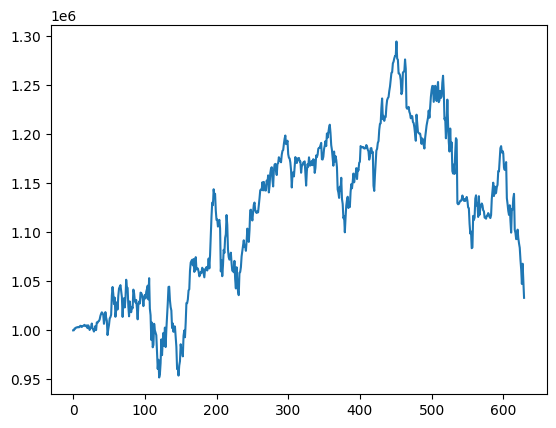

In [ ]:
%matplotlib inline
df_account_value.account_value.plot()

In [ ]:
df_a2c_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date),rebalance_window):
    temp = pd.read_csv('results/account_value_validation_{}_{}.csv'.format('A2C',i))
    df_a2c_value = df_a2c_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_a2c_value.account_value.pct_change(1).mean()/df_a2c_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_a2c_value=df_a2c_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.2233942456584851


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

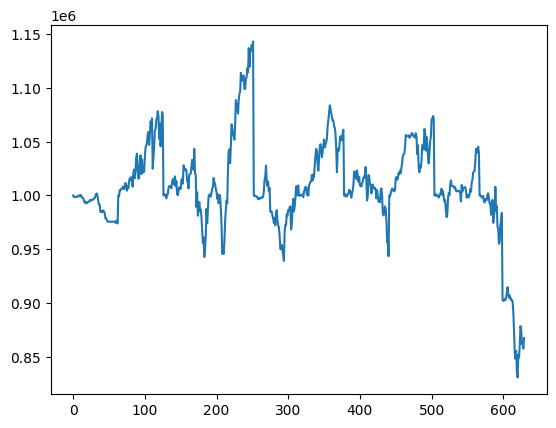

In [ ]:
%matplotlib inline
df_a2c_value.account_value.plot()

In [ ]:
df_ppo_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date),rebalance_window):
    temp = pd.read_csv('results/account_value_validation_{}_{}.csv'.format('PPO',i))
    df_ppo_value = df_ppo_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_a2c_value.account_value.pct_change(1).mean()/df_a2c_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_ppo_value=df_ppo_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.2233942456584851


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

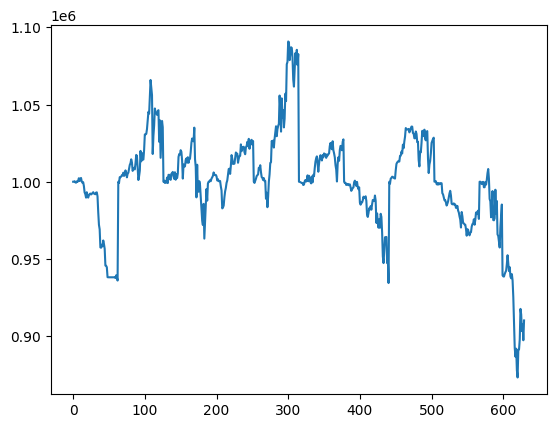

In [ ]:
%matplotlib inline
df_ppo_value.account_value.plot()

In [ ]:
df_ddpg_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date),rebalance_window):
    temp = pd.read_csv('results/account_value_validation_{}_{}.csv'.format('DDPG',i))
    df_ddpg_value = df_ddpg_value.append(temp,ignore_index=True)
sharpe=(252**0.5)*df_ddpg_value.account_value.pct_change(1).mean()/df_ddpg_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_ddpg_value=df_ddpg_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  0.031219960922328673


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

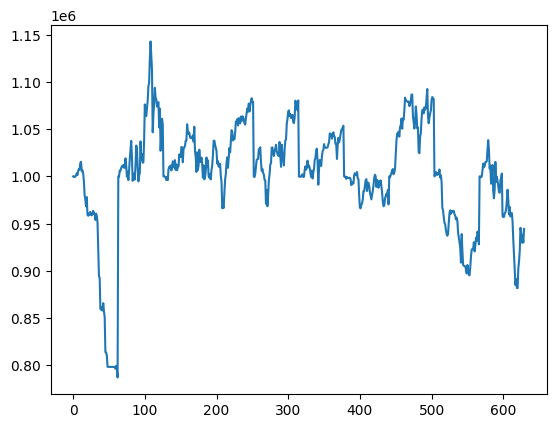

In [ ]:
%matplotlib inline
df_ddpg_value.account_value.plot()

In [ ]:
#BackTestStats
print("==============Get Backtest Results===========")
print("======================Ensemble=======================")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
======================Ensemble=======================
Annual return          0.013128
Cumulative returns     0.033144
Annual volatility      0.149156
Sharpe ratio           0.162338
Calmar ratio           0.065078
Stability              0.545071
Max drawdown          -0.201731
Omega ratio            1.028833
Sortino ratio          0.219375
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.930413
Daily value at risk   -0.018696
dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print("==============Get Backtest Results===========")
print("======================A2C=======================")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_a2c_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
======================A2C=======================
Annual return         -0.055191
Cumulative returns    -0.132320
Annual volatility      0.180006
Sharpe ratio          -0.223394
Calmar ratio          -0.202263
Stability              0.054063
Max drawdown          -0.272870
Omega ratio            0.949613
Sortino ratio         -0.267673
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.886316
Daily value at risk   -0.022838
dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print("==============Get Backtest Results===========")
print("======================PPO=======================")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_ppo_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
======================PPO=======================
Annual return         -0.036994
Cumulative returns    -0.089935
Annual volatility      0.132890
Sharpe ratio          -0.217648
Calmar ratio          -0.185253
Stability              0.070619
Max drawdown          -0.199693
Omega ratio            0.949733
Sortino ratio         -0.296346
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.894845
Daily value at risk   -0.016857
dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print("==============Get Backtest Results===========")
print("======================DDPG=======================")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_ddpg_value)
perf_stats_all = pd.DataFrame(perf_stats_all)

==============Get Backtest Results===========
======================DDPG=======================
Annual return         -0.022668
Cumulative returns    -0.055711
Annual volatility      0.257041
Sharpe ratio           0.031220
Calmar ratio          -0.099049
Stability              0.000272
Max drawdown          -0.228859
Omega ratio            1.008058
Sortino ratio          0.052603
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.844138
Daily value at risk   -0.032352
dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#baseline stats
print("==============Get Baseline Stats===========")
df_sp500_ = get_baseline(
        ticker="^GSPC",
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(df_sp500_, value_col_name = 'close')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


==============Get Baseline Stats===========
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (629, 8)
Annual return          0.157520
Cumulative returns     0.440686
Annual volatility      0.197045
Sharpe ratio           0.842326
Calmar ratio           0.653544
Stability              0.542290
Max drawdown          -0.241025
Omega ratio            1.155100
Sortino ratio          1.189602
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.934728
Daily value at risk   -0.024167
dtype: float64


In [ ]:
df_sp500 = pd.DataFrame()
df_sp500['date'] = df_account_value['date']
df_sp500['sp500'] = df_sp500_['close'] / df_sp500_['close'][0] * env_kwargs["initial_amount"]
print("df_sp500: ", df_sp500)
df_sp500.to_csv("df_sp500.csv")
df_sp500 = df_sp500.set_index(df_sp500.columns[0])
print("df_sp500: ", df_sp500)
df_sp500.to_csv("df_sp500+.csv")

df_account_value.to_csv('df_account_value.csv')


df_sp500:             date         sp500
0    2020-04-02  1.000000e+06
1    2020-04-03  9.848629e+05
2    2020-04-06  1.054130e+06
3    2020-04-07  1.052440e+06
4    2020-04-08  1.088282e+06
..          ...           ...
625  2022-09-26  1.446452e+06
626  2022-09-27  1.443385e+06
627  2022-09-28  1.471780e+06
628  2022-09-29  1.440686e+06
629  2022-09-30           NaN

[630 rows x 2 columns]
df_sp500:                     sp500
date                    
2020-04-02  1.000000e+06
2020-04-03  9.848629e+05
2020-04-06  1.054130e+06
2020-04-07  1.052440e+06
2020-04-08  1.088282e+06
...                  ...
2022-09-26  1.446452e+06
2022-09-27  1.443385e+06
2022-09-28  1.471780e+06
2022-09-29  1.440686e+06
2022-09-30           NaN

[630 rows x 1 columns]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


df_result_ensemble.columns:  Index(['ensemble'], dtype='object')
df_result_a2c.columns:  Index(['a2c'], dtype='object')
df_result_ppo.columns:  Index(['ppo'], dtype='object')
df_result_ddpg.columns:  Index(['ddpg'], dtype='object')
df_trade_date:         datadate
0    2020-01-02
1    2020-01-03
2    2020-01-06
3    2020-01-07
4    2020-01-08
..          ...
751  2022-12-23
752  2022-12-27
753  2022-12-28
754  2022-12-29
755  2022-12-30

[756 rows x 1 columns]
df_result_ensemble:                  ensemble
date                    
2020-04-02  1.000000e+06
2020-04-03  1.000049e+06
2020-04-06  1.001872e+06
2020-04-07  1.001838e+06
2020-04-08  1.002800e+06
...                  ...
2022-09-26  1.062025e+06
2022-09-27  1.047261e+06
2022-09-28  1.067856e+06
2022-09-29  1.050472e+06
2022-09-30  1.033144e+06

[630 rows x 1 columns]
df_result_a2c:                         a2c
date                      
2020-01-02  1000000.000000
2020-01-03   998782.548858
2020-01-06   998577.099570
2020-01-07   99

<Figure size 2000x1000 with 0 Axes>

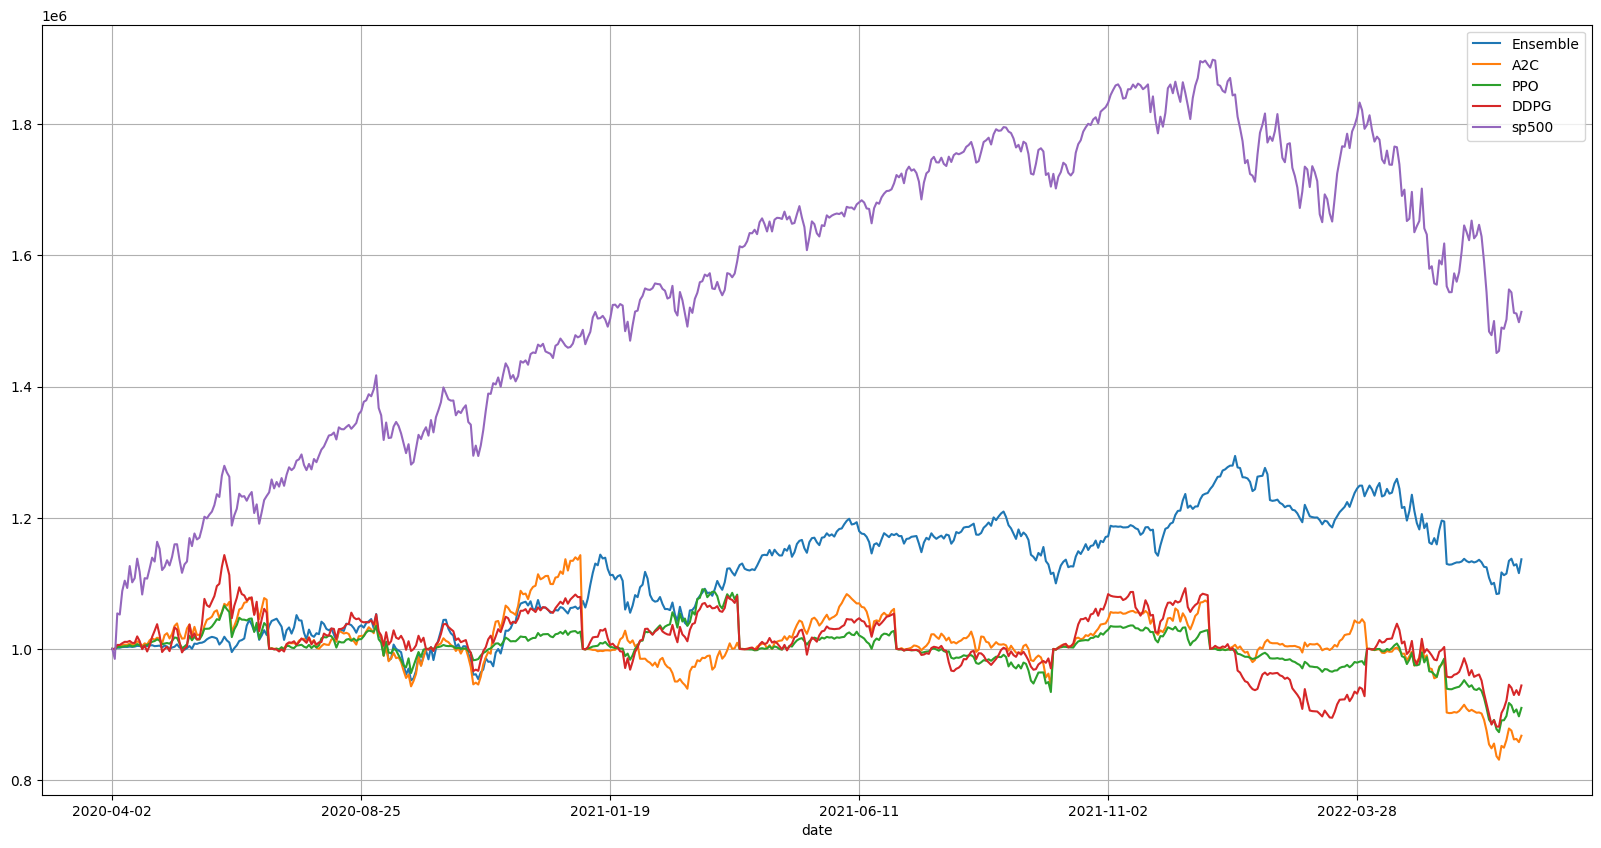

In [ ]:

df.to_csv("df.csv")
df_result_ensemble = pd.DataFrame({'date': df_account_value['date'], 'ensemble': df_account_value['account_value']})
df_result_ensemble = df_result_ensemble.set_index('date')

df_result_a2c = pd.DataFrame({'date': df_a2c_value['date'], 'a2c': df_a2c_value['account_value']})
df_result_a2c = df_result_a2c.set_index('date')

df_result_ppo = pd.DataFrame({'date': df_ppo_value['date'], 'ppo': df_ppo_value['account_value']})
df_result_ppo = df_result_ppo.set_index('date')

df_result_ddpg = pd.DataFrame({'date': df_ddpg_value['date'], 'ddpg': df_ddpg_value['account_value']})
df_result_ddpg = df_result_ddpg.set_index('date')

print("df_result_ensemble.columns: ", df_result_ensemble.columns)
print("df_result_a2c.columns: ", df_result_a2c.columns)
print("df_result_ppo.columns: ", df_result_ppo.columns)
print("df_result_ddpg.columns: ", df_result_ddpg.columns)
print("df_trade_date: ", df_trade_date)
df_result_ensemble.to_csv("df_result_ensemble.csv")
df_result_a2c.to_csv("df_result_a2c.csv")
df_result_ppo.to_csv("df_result_ppo.csv")
df_result_ddpg.to_csv("df_result_ddpg.csv")

print("df_result_ensemble: ", df_result_ensemble)
print("df_result_a2c: ", df_result_a2c)
print("df_result_ppo: ", df_result_ppo)
print("df_result_ddpg: ", df_result_ddpg)
print("==============Compare to S&P500===========")
result = pd.DataFrame()
result = pd.merge(df_result_ensemble, df_result_a2c, left_index=True, right_index=True)
result = pd.merge(result, df_result_ppo, left_index=True, right_index=True)
result = pd.merge(result, df_result_ddpg, left_index=True, right_index=True)
result = pd.merge(result, df_sp500, left_index=True, right_index=True)

print("result: ", result)
result.to_csv("result.csv")
result.columns = ['Ensemble','A2C','PPO','DDPG', 'sp500']

%matplotlib inline
plt.rcParams["figure.figsize"] = (20,10)
plt.figure();

ax = result.plot()
ax.grid(True)

plt.show()